In [1]:
import numpy as np
import neptune
import imageio
import scipy as scipy
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import os
import skimage as skim
from scipy.ndimage import rotate
from tqdm import tqdm as tqdm

import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from src.results.utils import FMNIST_CATEGORIES

from src.data_loader import _shift_image
from src.stimuli import FashionMNISTM as ShiftedDataBatcher
from src.test_models.crduplex import CR_DAE
from src.utils import save_model, save_model_and_weights, save_weights, prepare_dir
from src.plot import plot_img_row,remove_axes,remove_labels

Using TensorFlow backend.


# Experiment parameters

In [2]:
exp_date = '2020-04-11'
proj_root = '/home/elijahc/projects/vae'
models_root = prepare_dir(proj_root,'models',exp_date)

In [3]:
PROPS = {
    'dataset':'fashion_mnist',
    'encoder_arch': 'convnet',
    'generator_arch': 'resnet',
    'augmentation': 'dynamic',
}

PARAMS = {}

train_conf = {
    'n_epochs': 90000,
    'batch_sz':256,
}

data_conf = {
    'bg': 'natural',
    'im_translation':0.75,
    'bg_contrast': 0.5,
    'rotation':0.3,
}

model_conf = {
    'xent_weight': 15,
    'recon_weight': 0,
    'y_dim':500,
    'z_dim':0,
}

for conf in [train_conf,data_conf,model_conf]:
    PARAMS.update(conf)

# Initialize databatcher with experiment parameters

In [4]:
PARAMS = exp.get_parameters()

NameError: name 'exp' is not defined

In [5]:
DB = ShiftedDataBatcher(translation=PARAMS['im_translation'],
                        blend=None,
#                         scale=4,
                        rotation=PARAMS['rotation'],
#                         blend='difference',
                        batch_size=PARAMS['batch_sz'],
                       )

loading bsds500...


In [17]:
X,y,_ = next(DB.gen_train_batches(1))
x,fg,orig = X['whole'],X['foreground'],X['object']

In [ ]:
# x,fg,orig,y = DB.plot_example()

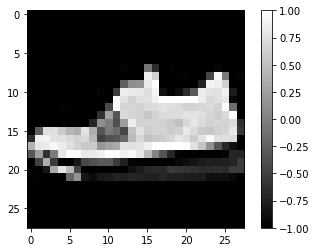

In [8]:
plt.imshow(np.squeeze(orig[3]),cmap='gray')
plt.colorbar()

# Initialize neptune monitoring

In [9]:
os.environ['NEPTUNE_API_TOKEN']="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vdWkubmVwdHVuZS5tbCIsImFwaV9rZXkiOiI3ZWExMTlmYS02ZTE2LTQ4ZTktOGMxMi0wMDJiZTljOWYyNDUifQ=="
neptune.init('elijahc/DuplexAE')
neptune.set_project('elijahc/DuplexAE')
from src.results.neptune import load_configs,load_models

In [10]:
exps = [
    'DPX-45',
]

In [11]:
exp = neptune.project.get_experiments(id=exps)[0]

In [13]:
load_models(proj_root=proj_root,experiments=exps)

<generator object load_models at 0x7f363c11bfc0>

In [ ]:
neptune.s

In [ ]:
exp.get_properties()['dir']

In [ ]:
exp = neptune.create_experiment(name='Lg_convE_w_recon',properties=PROPS,params=PARAMS,upload_source_files=src_files)
exp_dir = os.path.join('models',exp_date,exp.id)
exp.set_property('dir',exp_dir)

In [ ]:
prepare_dir(proj_root,exp_dir)
prepare_dir(proj_root,exp_dir,'recons')
prepare_dir(proj_root,exp_dir,'test_ims')

In [ ]:
mod = CR_DAE(input_shape=(112,112,1),output_shape=(112,112,1),n_residual_blocks=4,
             y_dim=PARAMS['y_dim'],z_dim=PARAMS['z_dim'],
               num_classes=DB.num_classes,
               recon=w_recon,
               xent=w_xent,
#                kernel_regularization=1e-5,
              )

In [ ]:
mod_dir = prepare_dir(proj_root,exp_dir)
mod_dir

# Save model description and initial weights

In [ ]:
save_model(mod.combined,mod_dir)
mod.combined.save_weights(os.path.join(mod_dir,'weights_0.h5'))

model_json = mod.combined.to_json()
with open(os.path.join(mod_dir,"model.json"), "w") as json_file:
    json_file.write(model_json)

In [ ]:
mod.combined.metrics_names

In [ ]:
i = 0
epoch_sz = int(DB.num_train/PARAMS['batch_sz'])
pan_ims = []
pan_y = []

# hist_labels = mod.combined.metrics_names
hist_labels = ['loss','G_loss','C_loss','G_mse','acc']

train_hist = []
test_hist = []

# val_X,val_X_fg,val_y = DB.gen_batch(DB.x_te,DB.y_test_oh,batch_size=1000,bg='natural')

In [ ]:
test_generator = DB.gen_test_batches(1, batch_size=PARAMS['batch_sz'])
ims,ty,_ = next(test_generator)
tX, tX_fg,tXsm = ims['whole'],ims['foreground'],ims['object']
cent = int((112-28)/2)
delt = int(cent*PARAMS['im_translation'])
p_min = int(cent-delt)
p_max = int(cent+delt)

height = np.random.randint(p_min,p_max,PARAMS['batch_sz'])

In [ ]:
def flush_pan(pan_ims):
    min_max = lambda xp: np.clip((xp+1)/2,0,1)
    for idx,inp,G in pan_ims:
        idx = str(idx).zfill(3)
        
#         inp_fn = 'input_{}.png'.format(idx)
#         inp_fp = os.path.join(proj_root,exp_dir,'test_ims',inp_fn)
        
        G_fn = 'G_{}.png'.format(idx)
        G_fp = os.path.join(proj_root,exp_dir,'recons',G_fn)
    
        fig,axs = plt.subplots(2,num_pan)
        for k in np.arange(num_pan):
            axs[0,k].imshow(inp[k],cmap='gray')
            axs[1,k].imshow(G[k],cmap='gray')

        for ax in axs.ravel():
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)

        plt.tight_layout()     
        
        fig.savefig(G_fp)
        plt.close(fig)

In [ ]:
recon_dir = prepare_dir(proj_root,exp_dir,'recons')
# input_dir = prepare_dir(proj_root,exp_dir,'test_ims')

In [ ]:
def make_gif(recon_dir,input_dir,fps=8,loop=0):
    G_ims = []
    for G in sorted(os.listdir(recon_dir)):
        if G.endswith('.png'):
            G_fp = os.path.join(recon_dir, G)
            G_ims.append(imageio.imread(G_fp))
        
#     imageio.mimsave(os.path.join(proj_root,exp_dir,'inputs_video.gif'), input_ims,fps=fps,loop=loop)
    imageio.mimsave(os.path.join(proj_root,exp_dir,'G_video.gif'), G_ims, fps=fps,loop=loop)

In [ ]:
# x_span = DB.gen_pan_deltas(step=2)
# pX = np.stack([DB._translate_image(px_[1],dx,dy) for dx,dy in x_span])



# scaler = MinMaxScaler(feature_range=(-1,1))
# n,x,y,c = pX.shape

# pX = scaler.fit_transform(pX.reshape(n,x*y*c)).reshape(n,x,y,c)

In [ ]:
def plot_test_grid(hist):

    fig,axs = plt.subplots(2,4,figsize=(10,5))

    G_axs = axs[0]
    C_axs = axs[1]
    
    if len(hist) > 151:
        hist_tr = hist.iloc[-150:]
    else:
        hist_tr = hist
    
    sns.lineplot(x='batch',y='G_loss',hue='result_type',data=hist_tr,ax=G_axs[0],legend=False)
    G_axs[0].set_title('vG_loss: {}'.format(int(r_te['G_loss'])))
#     G_axs[0].set_yscale('log')

    sns.lineplot(x='batch',y='acc',hue='result_type',data=hist_tr,ax=C_axs[0],legend=False)
    C_axs[0].set_title('vAcc: {:02.1%}'.format(r_te['acc']))

    G_axs[1].imshow(np.squeeze(n_im),cmap='gray',vmin=-1,vmax=1)
    G_axs[1].set_title('Test Image')
    C_axs[1].imshow(np.squeeze(n_im),cmap='gray',vmin=-1,vmax=1)
    remove_labels(C_axs[1])
    remove_axes(C_axs[1])

    G_axs[2].imshow(np.squeeze(p_recon),cmap='gray',vmin=-1,vmax=1)
    G_axs[2].set_title('Prediction')
    C_axs[2].set_title(FMNIST_CATEGORIES[np.argmax(p_class)])
    c = ['blue']*10
    c[np.argmax(p_class)]='green'
    C_axs[2].barh(np.arange(10),np.squeeze(p_class),color=c)
    C_axs[2].set_xlim(0,1)

    G_axs[3].imshow(np.squeeze(im),cmap='gray',vmin=-1,vmax=1)
    G_axs[3].set_title('Goal')
    C_axs[3].barh(np.arange(10),ty[t_idx],color=['green']*10)
    C_axs[3].set_title(FMNIST_CATEGORIES[np.argmax(ty[t_idx])])

    C_axs[3].set_yticks(np.arange(10))
    C_axs[3].set_yticklabels(FMNIST_CATEGORIES)
    C_axs[2].set_yticks(np.arange(10))
    C_axs[2].set_yticklabels(FMNIST_CATEGORIES)

    for gax in G_axs[1:].ravel():
        remove_labels(gax)
        remove_axes(gax)



    plt.tight_layout()
    
    return fig,axs
# plot_test_grid()

In [ ]:
# mod.combined.save_weights(os.path.join(mod_dir,'weights_{}.h5'.format(i)))

In [ ]:
def error_rate_by_class(y_true,y_pred,softmax=True,normalized=True):
    batch_size,n_classes = y_true.shape
    te_int = np.argmax(y_true,axis=1)
    y_p_int = np.argmax(y_pred,axis=1)
    error_classes = te_int[te_int!=y_p_int]
    
    n_each_class = np.bincount(te_int,minlength=n_classes)
    
    expected_errors_per_class = n_each_class*(len(error_classes)/batch_size)

    per_class_errors = np.bincount(error_classes,minlength=n_classes)
    
    normalized_error_rates = per_class_errors/expected_errors_per_class
    
    if softmax:
        return np.exp(normalized_error_rates)/np.exp(normalized_error_rates).sum()
    elif normalized:
        return normalized_error_rates
    else:
        return per_class_errors

In [ ]:
cent = int((112-28)/2)
delt = int(cent*PARAMS['im_translation'])
p_min = int(cent-delt)
p_max = int(cent+delt)
pdx = np.linspace(p_min,p_max,int(p_max-p_min),dtype=int)
rdx = np.linspace(-180*PARAMS['rotation'],180*PARAMS['rotation'],len(pdx))

first_idxs = [np.where(np.argmax(ty,axis=1)==k)[0][0] for k in np.arange(10)]

train_batches = DB.gen_train_batches(PARAMS['n_epochs']-i)
test_batches = DB.gen_test_batches(PARAMS['n_epochs']-i)

with tqdm(train_batches, miniters=5, total=PARAMS['n_epochs'],initial=i) as batch:
    for X_images,tr_y,meta in batch:
        X,X_fg,Xsm = X_images['whole'],X_images['foreground'],X_images['object']
        if i > 0 and i % 50 == 0:
            te_ims,te_y,_ = next(test_batches)
            te_X,te_Xfg,te_Xsm = te_ims['whole'],te_ims['foreground'],te_ims['object']
            r_te = mod.combined.test_on_batch(te_X,{'Classifier':te_y,
                                                  'Generator':te_Xfg
                                                 })
            
            _,y_p = mod.combined.predict(te_X)
            
            norm_err_rates = error_rate_by_class(te_y,y_p,softmax=False,normalized=True)
            
            r_te = {k:v for k,v in zip(hist_labels,r_te)}
            exp.log_metric('batch',i)
            for metric in hist_labels:
                exp.log_metric(metric,r[metric])
                exp.log_metric('val_{}'.format(metric),r_te[metric])
            r_te['batch']=i
            r_te['result_type'] = 'valid'

            train_hist.append(r)
            train_hist.append(r_te)
            p_epoch = "{:5d} ".format(i)
            p_loss = "loss[G+C]:[{:2.2f}+{:.2f}] / [{:2.2f}+{:.2f}] ".format(r['G_loss'],r['C_loss'],r_te['G_loss'],r_te['C_loss'])
            p_acc = "acc: [{:02.2%}] / [{:02.2%}] ".format(r['acc'],r_te['acc'])
            batch.set_postfix(Acc=r['acc'],Acc_val=r_te['acc'],G_loss_val=r_te['G_loss'],G_loss=r['G_loss'],)    
            batch.set_description(p_epoch)
        
        if i in [50,100,150,300] or i%200 == 0:
            if i != 0:
                
                pdx_idx = int((i/100)%len(pdx))
                t_idx = first_idxs[int(i/100/len(pdx)%PARAMS['batch_sz']%10)]

#                 im_sm = tXsm
                im_ = DB.sm_scaler.inverse_transform(tXsm.reshape(tXsm.shape[0],-1)).reshape(*tXsm.shape)
#                 im_ = DB.sm_scaler.inverse_transform(te_Xsm.reshape(te_Xsm.shape[0],-1)).reshape(*te_Xsm.shape)
#     DB.sm_scaler.transform((tXsm[0]/255.0).reshape(1,-1)).reshape(1,28,28,1)
                im = rotate(im_[t_idx],rdx[pdx_idx],reshape=False)
                im = DB._translate_image(im,height[t_idx],pdx[pdx_idx])
                im = DB.scaler.transform(im.reshape(1,-1)).reshape(1,112,112,1)
                n_im = skim.util.random_noise(im,mode='gaussian',var=0.10,mean=0.0,clip=True,)
                p_recon,p_class = mod.combined.predict_on_batch(n_im)

                batch.set_description('writing_image_buffer...')
                hist = pd.DataFrame.from_records(train_hist)
                
                fig,axs = plot_test_grid(hist)
                fig.savefig(os.path.join(recon_dir,'recon_{}.png'.format(str(i).zfill(5))))
                plt.close(fig)
                batch.set_description(p_epoch)

        
        y = {'Classifier':tr_y,
             'Generator':X_fg,
            }
        if i>50:
            c_weight = {k:w for k,w in enumerate(norm_err_rates)}
        else:
            c_weight = None

        r = mod.combined.train_on_batch(X,y,class_weight=c_weight)
        r = {k:v for k,v in zip(hist_labels,r)}
        r['result_type'] = 'train'
        r['batch']=i
#                 subprocess.run(['convert', '-delay', '20', '-loop', '0', '*.png', 'recon_learning.gif'])
#                 url = subprocess.run(['imgur-uploader', 'recon_learning.gif',],stdout=subprocess.PIPE).stdout.decode('utf-8')
#                 exp.set_property('recon_gif',url)
        

        i+=1

In [ ]:
X,X_fg,y = next(DB.gen_train_batches(PARAMS['n_epochs'],bg=PARAMS['bg']))

In [ ]:
i

In [ ]:
flush_pan(pan_ims)
pan_ims = []
make_gif(recon_dir,input_dir,)

In [ ]:
mod_dir = os.path.join(proj_root,exp_dir)
mod_dir

In [ ]:
hist_tr = pd.DataFrame.from_records(train_hist)

In [ ]:
# sns.set_context('talk')
# fig,axs = plt.subplots(1,4,figsize=(4*4,1*4),sharex=True)
# for ax,metric in zip(axs.ravel(),['loss','G_loss','C_loss','acc']):
#     sns.lineplot(x='batch',y=metric, hue='result_type',data=hist_tr,ax=ax)

In [ ]:
print(mod_dir)
hist_tr.to_csv(os.path.join(mod_dir,'training_hist.csv'))

In [ ]:
model_json = mod.combined.to_json()
with open(os.path.join(mod_dir,"model.json"), "w") as json_file:
    json_file.write(model_json)
    
exp.send_artifact(os.path.join(mod_dir,'model.json'))

In [ ]:
mod.combined.save_weights(os.path.join(mod_dir,'weights_{}.h5'.format(i)))

In [ ]:
mod.combined.save_weights(os.path.join(mod_dir,'weights.h5'))

In [ ]:
exp.stop()

In [ ]:
mod.G.summary()

In [ ]:
teX,teX_fg,te_y = next(test_generator)

In [ ]:
res = mod.combined.evaluate(teX,{'Classifier':te_y,'Generator':teX_fg},batch_size=PARAMS['batch_sz'])


In [ ]:
res

In [ ]:
nteX = skim.util.random_noise(teX,mode='gaussian',var=0.2)
nout = mod.combined.predict_on_batch(nteX)

In [ ]:
out = mod.combined.predict_on_batch(teX)
x_recon,y = out
n_recon,ny = nout

In [ ]:
choices = np.random.choice(np.arange(512),size=5,replace=False)

In [ ]:
fix,axes = plt.subplots(2,5,figsize=(2*5,2*2))

for i,idx in enumerate(choices):
    axs = axes[:,i]
    axs[0].imshow(teX[idx].reshape(56,56),cmap='gray',vmin=-1,vmax=1)
    axs[1].imshow(x_recon[idx].reshape(56,56),cmap='gray',vmin=-1,vmax=1)
    
for ax in axes.ravel():
    ax.get_yaxis().set_visible(False)
    ax.get_xaxis().set_visible(False)
    
plt.tight_layout()

In [ ]:
fig.savefig(os.path.join(mod_dir,'inp_output_pairs.png'),dpi=150)

In [ ]:
exp.send_artifact(os.path.join(mod_dir,'inp_output_pairs.png'))

In [ ]:
fix,axes = plt.subplots(2,5,figsize=(2*5,2*2))

for i,idx in enumerate(choices):
    axs = axes[:,i]
    axs[0].imshow(nteX[idx].reshape(56,56),cmap='gray',vmin=-1,vmax=1)
    axs[1].imshow(n_recon[idx].reshape(56,56),cmap='gray',vmin=-1,vmax=1)
    
for ax in axes.ravel():
    ax.get_yaxis().set_visible(False)
    ax.get_xaxis().set_visible(False)
    
plt.tight_layout()